In [1]:
#import statements
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import io
import scipy.misc as im
from scipy import ndimage
import sys
import math
%matplotlib inline
sys.setrecursionlimit(20000)

# 1: Binarization, Otsu's Method

In [2]:
def grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

#convert grayscale intensities from 0-1 to 0-255
def convert_intensities(gray_img):
    out = []
    for row in gray_img:
        out.append([round(255*pix) for pix in row])
    return out

In [3]:
#create bins for each of the intensity values
def intensity_hist(img):
    out = [0 for i in range(256)]
    for row in img:
        for pix in row:
            out[int(pix)] += 1
    return out

#create probability density function using the histogram:
def generate_pdf(h,img):
    #total number of pixels in the image:
    total = len(img)*len(img[0])
    p = [1 for i in range(256)]
    for i in range(len(h)):
        p[i] = h[i] / total
        if p[i] == 0:
            p[i] = 0.000000001
    return p

In [4]:
#compute class probabilities:
def class_probs(p, index):
    q1 = sum(p[:index])
    q2 = sum(p[index:])
    return q1, q2

#compute class means:
def class_means(p, index, q1, q2):
    u1 = 0.0
    u2 = 0.0
    
    for i in range(1, index):
        u1 += (i*p[i]/q1)
        
    for j in range(index, 255):
        u2 += (j*p[j]/q2)
    
    return u1, u2

#compute between class variance:
def between_class_variance(p):
    
    #initialize max 
    max_thresh = 0
    max_variance = 0
    
    #loop through all possible threshold values
    for thresh in range(1,255):
        #get class probs and class means for this threshold value:
        qv1, qv2 = class_probs(p, thresh)
        uv1, uv2 = class_means(p, thresh, qv1, qv2)
        sigma = qv1*(1-qv1)*((uv1-uv2)**2)
        
        #check if this variance is greater than current max:
        if sigma > max_variance:
            max_variance = sigma
            max_thresh = thresh
            
    return max_thresh
        

In [5]:
#binarize image based on a given threshold
def binarize(img, th, dark):
    out = []
    for row in img:
        r = []
        for pix in row:
            if pix > th:
                if dark == True:
                    r.append(0)
                else:
                    r.append(1)
            else:
                if dark == True:
                    r.append(1)
                else:
                    r.append(0)
        out.append(r)
    return np.asarray(out)

In [6]:
#otsu's method function:
def otsu(image, dark, png):
    
    #compute grayscale version of the image:
    gray = grayscale(image)
    
    if png == True:
        gray = convert_intensities(gray)
    
    #compute histogram of intensity values:
    histogram = intensity_hist(gray)
    
    #compute probability density function:
    prob_func = generate_pdf(histogram, gray)
    
    #find threshold that maximizes between class variance:
    threshold = between_class_variance(prob_func)
    
    #binarize image based on this threshold:
    binary_image = binarize(gray, threshold, dark)
    
    return binary_image

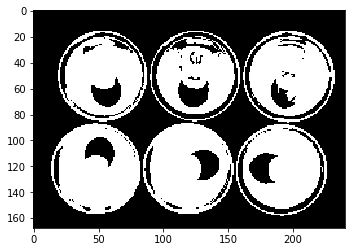

In [7]:
#run otsu's method function:
cans = mpimg.imread("hw3/files/can_pix.png")
o = otsu(cans, False, True)
plt.imshow(o, cmap='gray')

# 2.1.a: Connected Regions

In [8]:
#function to get all the neighbors of a given pixel:
def neighbors(x,y, img):
    neigh = [[x-1,y-1], [x,y-1], [x+1,y-1], \
        [x-1,y], [x+1,y], \
         [x-1,y+1], [x,y+1], [x+1,y+1]]
    
    #remove invalid neighbors:
    for n in neigh:
        if n[0] < 0 or n[0] > len(img) or n[1] < 0 or n[1] > len(img[0]):
           neigh.remove(n)
    
    return neigh
    

In [9]:
#create mark matrix:
def label(x,y,m,img,mark):
    
    mark[x][y] = m
    adjacent = neighbors(x,y, img)
    
    for n in adjacent:
        if img[n[0]][n[1]] == 1 and mark[n[0]][n[1]] == 0:
            label(n[0],n[1],m,img,mark)

def find_connected_regions(img):
    
    mark = [[0 for j in range(len(img[0]))] for i in range(len(img))]
    
    #initialize marker
    marker = 0
    
    #loop through each pixel in the image:
    for i in range(len(img)):
        for j in range(len(img[i])):
            
            #if this pixel hasn't been labelled, and it's value is 1,
            #start recursively looking to label all of its neighbors:
            if img[i][j] == 1 and mark[i][j] == 0:
                marker += 1
                label(i,j,marker,img,mark)
    
    return mark
                
            

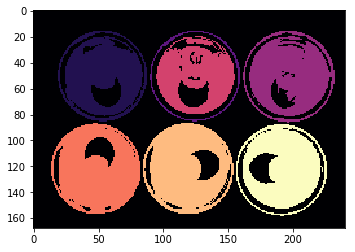

In [10]:
me = find_connected_regions(o)
plt.imshow(me, cmap='magma')
plt.savefig("hw3/files/cans_connected.png")

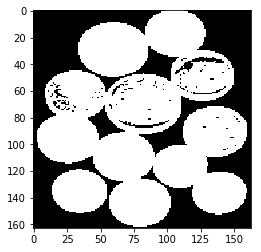

In [11]:
#look at coins pix:
coins = mpimg.imread("hw3/files/coins_pix.jpg")
coins = im.imresize(coins, (int(len(coins)/2), int(len(coins)/2)))
o_coins = otsu(coins, True, False)
plt.imshow(o_coins, cmap="gray")

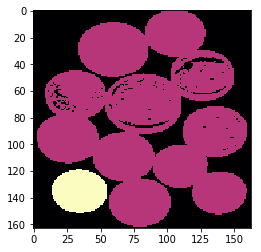

In [12]:
connected_coins = find_connected_regions(o_coins)
plt.imshow(connected_coins, cmap="magma")

# 2.2 Take your own images

In [13]:
#load images:
lizard = mpimg.imread("hw3/files/xbox.jpg")
card = mpimg.imread("hw3/files/pad.jpg")
pl = mpimg.imread("hw3/files/box.jpg")

In [14]:
small_lizard = im.imresize(lizard, (200,200))
o_lizard = otsu(small_lizard, False, False)
con_lizard= find_connected_regions(o_lizard)


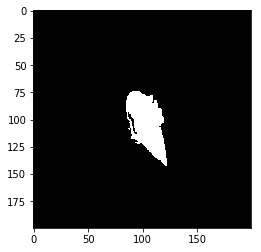

In [15]:
plt.imshow(con_lizard, cmap="gray")

In [16]:
sl = im.imresize(card, (200,200))
oh = otsu(sl, True, False)

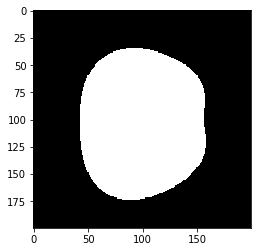

In [17]:
cn = find_connected_regions(oh)
plt.imshow(cn, cmap="gray")


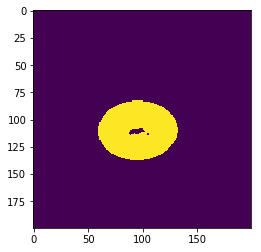

In [18]:
small_pl = im.imresize(pl, (200,200))
o_jelly = otsu(small_pl, False, False)
plt.imshow(o_jelly)
#con_jelly = find_connected_regions(o_jelly)

# 2.3 Image moments and rectification

In [19]:
#function to compute raw moment:
def raw_moment(img, j, k, d):
    
    #initialize moment
    moment = 0.0
    
    for x in range(len(img)):
        for y in range(len(img[x])):
            
            #sum if this pixel is part of our object:
            if img[x][y] == d:
                moment += (x**j)*(y**k)
    
    return moment

#compute location of centroid:
def centroid(img, d):
    
    #get area of the object:
    area = raw_moment(img, 0, 0, d)
    
    #get moment in the x direction, y direction:
    x_mom = raw_moment(img, 1, 0, d)
    y_mom = raw_moment(img, 0, 1, d)
    
    #compute x and y coordinates of centroid:
    x_cent = int(x_mom/area)
    y_cent = int(y_mom/area)
    
    return y_cent, x_cent

def central_moment(img, j, k, d):
    
    #initialize moment:
    moment = 0.0
    
    #get moment in x, y directions:
    x_bar = raw_moment(img, 1, 0, d) / raw_moment(img,0,0,d)
    y_bar = raw_moment(img, 0, 1, d) / raw_moment(img,0,0,d)
    
    #loop through each pixel in our image:
    for x in range(len(img)):
        for y in range(len(img[x])):
            
            #sum if this pixel is part of our object:
            if img[x][y] == d:
                moment += ((x-x_bar)**j)*((y-y_bar)**k)
                
    return moment

def normalized_moment(img, j, k, d):
    
    #initialize moment:
    moment = 0.0
    
    #compute area of our object:
    area = raw_moment(img, 0 , 0, d)
    
    #get moment in x, y directions:
    x_bar, y_bar = centroid(img, j, k, d)
    
    #compute second order central moments:
    central_x = central_moment(img, 2, 0, d)
    central_y = central_moment(img, 0, 2, d)
    
    #compute sigmas:
    sigma_x = (central_x/area)**0.5
    sigma_y = (central_y/area)**0.5
    
    #loop through each pixel in our image:
    for x in range(len(img)):
        for y in range(len(img[x])):
            
            if img[x][y] == d:
                moment += (((x-x_bar)/sigma_x)**j)*(((y-y_bar)/sigma_y)**k)
                
    return moment

def principal_axes(img, d):
    
    #compute second centralized moment matrix (scmm):
    u_20 = central_moment(img, 2, 0, d)
    u_11 = central_moment(img, 1, 1, d)
    u_02 = central_moment(img, 0, 2, d)
    
    scmm = [[u_02, u_11], \
            [u_11, u_20]]
    
    #compute eigenvectors of the scmm
    eigen = np.linalg.eig(scmm)[1]
    
    return eigen

def plot_eigenvectors(img, d):
    
    #get centroid:
    cent_x, cent_y = centroid(img, d)
    
    #get eigenvectors:
    ev = principal_axes(img, d)
    
    fig = plt.imshow(img, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    eig1 = np.array([cent_x, cent_y, (ev[0][0])*60, (ev[1][0])*60])
    eig2 = np.array([cent_x, cent_y, (ev[0][1])*60, (ev[1][1])*60])
    ax = plt.gca()
    ax.quiver(eig1[0], eig1[1], eig1[2], eig1[3], angles='xy', scale_units='xy', scale=1, color='r')
    ax.quiver(eig2[0], eig2[1], eig2[2], eig2[3], angles='xy', scale_units='xy', scale=1, color='b')

    plt.draw()
    plt.show()

In [23]:
v = principal_axes(o_squiggo, 1)
print(centroid(o_squiggo, 1))

(51, 68)


In [24]:
j_cent = centroid(o_jelly, 1)
print(j_cent)

(95, 109)


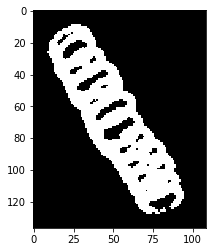

In [25]:
#test with squiggo:
squiggo = mpimg.imread("hw3/files/squiggo.jpg")
small_squiggo = im.imresize(squiggo, (200,200))
o_squiggo = otsu(squiggo, False, False)
plt.imshow(o_squiggo,cmap="gray")

In [26]:
x,y  = centroid(o_squiggo, 1)

In [27]:
v = principal_axes(o_squiggo, 1)
print(v)

[[-0.85138741 -0.5245374 ]
 [ 0.5245374  -0.85138741]]


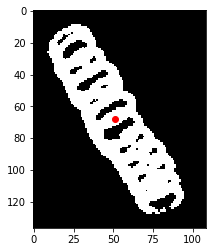

In [28]:
#overlay centroid and eigenvectors onto squiggo:
plt.scatter(x,y,c="r")
plt.imshow(o_squiggo,cmap="gray")

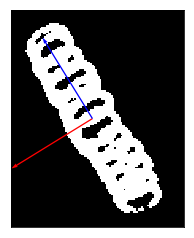

In [29]:
plot_eigenvectors(o_squiggo, 1)

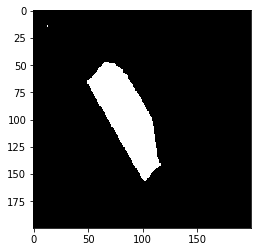

In [30]:
#load clean:
clean = mpimg.imread("hw3/files/clean.jpg")
small_clean = im.imresize(clean, (200,200))
o_clean = otsu(small_clean, True, False)
plt.imshow(o_clean,cmap="gray")

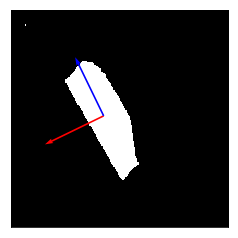

In [31]:
plot_eigenvectors(o_clean,1)

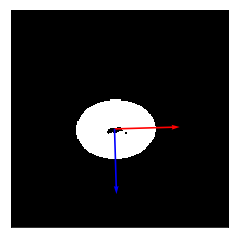

In [32]:
plot_eigenvectors(o_jelly, 1)

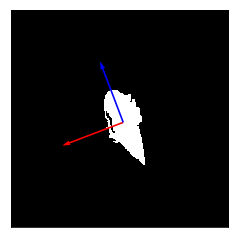

In [33]:
plot_eigenvectors(o_lizard,1)

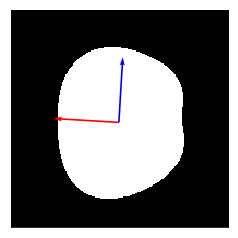

In [34]:
plot_eigenvectors(cn, 1)

# 2.4 Image alignment

In [35]:
#function to rotate image across its principal axis:
def align_image(img, d):
    
    #compute eigenvectors of the image:
    ev = principal_axes(img, 1)[1]
    
    #compute centroid of the image:
    x_cent, y_cent = centroid(img, d)
    
    #compute angle between normalized eigenvector and the x axis:
    x_axis = [1,0]
    theta = np.arccos(np.clip(np.dot(ev, x_axis), -1.0, 1.0))
    
    #create rotation matrix:
    R = np.array([[math.cos(theta),math.sin(theta)], \
                  [-math.sin(theta),math.cos(theta)]])

    print('Rot matrix: ', R)
    #make an empty image matrix of the same size as the input image:
    out_img = [[0 for i in range(len(img[j]))] for j in range(len(img))]
    
    #do the transformation function on each pixel of the input image:
    for i in range(len(img)):
        for j in range(len(img[i])):
            
            #move i and j coordinates based on centroid:
            xy_cent = [i-x_cent, j-y_cent]
            
            #multiply R and xy_cent:
            xy_rotate = np.matmul(R, xy_cent)
            
            #add centroids to the rotated matrix:
            x = int(xy_rotate[0] + x_cent)
            y = int(xy_rotate[1] + y_cent)
            
            #update output image:
            if x < len(img) and x >= 0 and y < len(img[0]) and y > 0:
                out_img[i][j] = img[x][y]
            
            
    return out_img
    


Rot matrix:  [[ 0.5245374   0.85138741]
 [-0.85138741  0.5245374 ]]


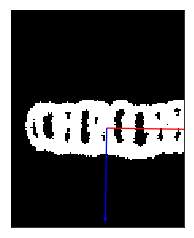

In [36]:
rot = align_image(o_squiggo, 1)
plot_eigenvectors(rot, 1)

Rot matrix:  [[ 0.3556314   0.93462629]
 [-0.93462629  0.3556314 ]]


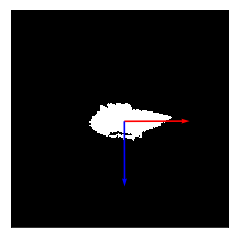

In [37]:
rot_lizard = align_image(o_lizard,1)
plot_eigenvectors(rot_lizard,1)

Rot matrix:  [[-0.05920353  0.99824593]
 [-0.99824593 -0.05920353]]


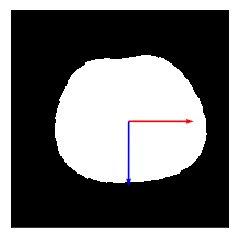

In [38]:
rot_cn = align_image(cn, 1)
plot_eigenvectors(rot_cn, 1)

Rot matrix:  [[ 0.43716872  0.89937951]
 [-0.89937951  0.43716872]]


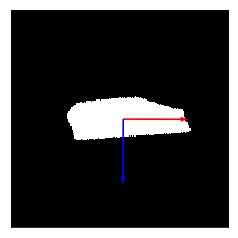

In [39]:
rot_clean = align_image(o_clean,1)
plot_eigenvectors(rot_clean,1)

# 3.1: Mickey Detection

In [40]:
#load image and filter:
mickey_filter = mpimg.imread("hw3/files/filter.jpg")
toy = mpimg.imread("hw3/files/toy.png")

In [41]:
#subtract mean image intensity from the image:
def modify(img):
        
    #get the mean pixel intensity:
    mean = 0.0
    total = 0
    for i in range(len(img)):
        for j in range(len(img[i])):
            mean += img[i][j]
            total += 1
    mean = mean / total
    
    #create a new image by subtracting all of the pixel values by the mean:
    out = [[0 for i in range(len(img[j]))] for j in range(len(img))]
    
    for i in range(len(img)):
        for j in range(len(img[i])):
            out[i][j] = img[i][j] - mean
    
    return out



#modified from hw2 script
def plot_square_colors(verts, x_min, x_max, y_min, y_max, img, colors):
    
    fig = plt.figure()    
    plt.imshow(img, cmap='gray')
    ax = fig.add_subplot(111)
    
    for i in range(len(verts)):
        print(i)
        codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
        path = Path(verts[i], codes)
        ax.set_ylim(y_min, y_max)
        ax.set_ylim(ax.get_ylim()[::-1])
        patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor=colors[i])
        ax.add_patch(patch)
        ax.set_xlim(x_min, x_max)

    plt.show()
    
#modified from hw2 script
def plot_square(verts, x_min, x_max, y_min, y_max, img):
    
    fig = plt.figure()    
    plt.imshow(img, cmap='gray')
    ax = fig.add_subplot(111)
    
    for i in range(len(verts)):
        codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
        path = Path(verts[i], codes)
        ax.set_ylim(y_min, y_max)
        ax.set_ylim(ax.get_ylim()[::-1])
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(x_min, x_max)

    plt.show()

#plot bounding box:
def bounding_box(img, f, val, plot):
    
    #subtract mean intensity from image and filter:
    mod_img = modify(img)
    mod_f = modify(f)
    
    #get intensity heatmap of the image:
    heatmap = ndimage.correlate(mod_img, mod_f)
    
    #get the max values of the heatmap:
    centers = []
    max_val = 0.0
    for i in range(len(heatmap)):
        for j in range(len(heatmap[i])):
            if heatmap[i][j] > max_val:
                max_val = heatmap[i][j]
    
    for i in range(len(heatmap)):
        for j in range(len(heatmap[i])):
            if heatmap[i][j] == max_val:
                centers.append([i,j])
    
    #adjust centers so the correspond to lower left corner of bounding box
    box_verts = []
    for c in centers:
        #bottom left:
        bly = c[0] - len(f)/2 + val
        blx = c[1] + len(f[0])/2 - val
        
        #bottom right
        bry = c[0] + len(f)/2 - val
        brx = blx
        
        #top left:
        tly = bly
        tlx = c[1] - len(f[0])/2 + val
        
        #top right:
        tr_y = bry
        trx = tlx
        
        box_verts.append([[blx,bly], [tlx,tly], [trx, tr_y], [brx, bry], [0,0]])
    
    if plot == True:
        plot_square(box_verts, 0, len(img[0]), 0, len(img), img)
    
    return box_verts
    
def make_heatmap(img, f):
    
    #subtract mean intensity from image and filter:
    mod_img = modify(img)
    mod_f = modify(f)
    
    #get intensity heatmap of the image:
    heatmap = ndimage.correlate(mod_img, mod_f)
    return heatmap

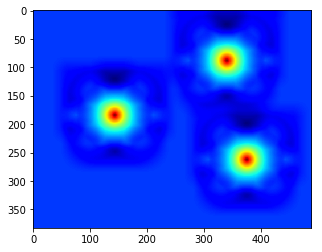

In [42]:
plt.imshow(make_heatmap(toy, mickey_filter),cmap="jet")

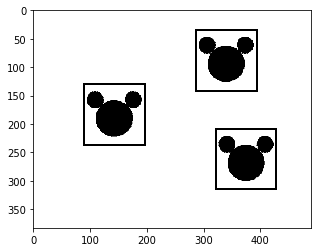

[[[393.5, 34.5], [286.5, 34.5], [286.5, 141.5], [393.5, 141.5], [0, 0]],
 [[196.5, 130.5], [89.5, 130.5], [89.5, 237.5], [196.5, 237.5], [0, 0]],
 [[428.5, 208.5], [321.5, 208.5], [321.5, 315.5], [428.5, 315.5], [0, 0]]]

In [43]:
bounding_box(toy, mickey_filter,10,True)

# 3.2: Detection Quality

In [44]:
#make ground truth bounding boxes:
#calculate how good predicted bounding box is versus ground truth:
def compare_bounding_boxes(predicted, ground_truth):
    
    #get the x and y limits of the predicted bounding box:
    p_ux = int(predicted[0][0])
    p_lx = int(predicted[2][0])
    p_ly = int(predicted[0][1])
    p_uy = int(predicted[2][1])
    
    #get the x and y limits of the ground truth bounding box:
    g_ux = int(ground_truth[0][0])
    g_lx = int(ground_truth[2][0])
    g_ly = int(ground_truth[0][1])
    g_uy = int(ground_truth[2][1])
    
    #compute the percentage of pixels that are common:
    common_pixels = 0.0
    total = 0.0

    for x in range(p_lx, p_ux):
        for y in range(p_ly, p_uy):
            
            #check if the ground truth pixel is in range of the predicted
            if x >= g_lx and x <= g_ux and y >= g_ly and y <= g_uy:
                common_pixels += 1
            total += 1
    out = (common_pixels / total)*100
    return out

In [45]:
g1 = bounding_box(toy, mickey_filter, 10, False)[0]
g2 = bounding_box(toy, mickey_filter, 20, False)[0]
g3 = bounding_box(toy, mickey_filter, 5, False)[0]
p1 = bounding_box(toy, mickey_filter, 0, False)[0]


72.31694463388926


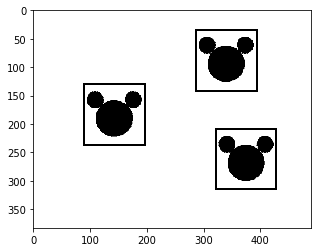

[[[393.5, 34.5], [286.5, 34.5], [286.5, 141.5], [393.5, 141.5], [0, 0]],
 [[196.5, 130.5], [89.5, 130.5], [89.5, 237.5], [196.5, 237.5], [0, 0]],
 [[428.5, 208.5], [321.5, 208.5], [321.5, 315.5], [428.5, 315.5], [0, 0]]]

In [46]:
print(compare_bounding_boxes(p1, g1))
bounding_box(toy, mickey_filter, 10, True)

48.01289602579205


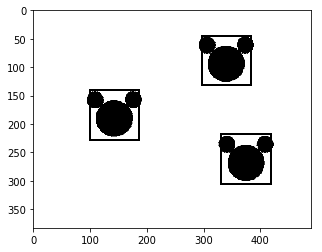

[[[383.5, 44.5], [296.5, 44.5], [296.5, 131.5], [383.5, 131.5], [0, 0]],
 [[186.5, 140.5], [99.5, 140.5], [99.5, 227.5], [186.5, 227.5], [0, 0]],
 [[418.5, 218.5], [331.5, 218.5], [331.5, 305.5], [418.5, 305.5], [0, 0]]]

In [47]:
print(compare_bounding_boxes(p1, g2))
bounding_box(toy, mickey_filter, 20, True)

86.32897265794531


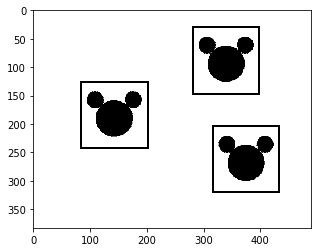

[[[398.5, 29.5], [281.5, 29.5], [281.5, 146.5], [398.5, 146.5], [0, 0]],
 [[201.5, 125.5], [84.5, 125.5], [84.5, 242.5], [201.5, 242.5], [0, 0]],
 [[433.5, 203.5], [316.5, 203.5], [316.5, 320.5], [433.5, 320.5], [0, 0]]]

In [48]:
print(compare_bounding_boxes(p1, g3))
bounding_box(toy, mickey_filter, 5, True)

# 3.3: Car Detection

In [49]:
#load car files:
car1 = mpimg.imread("hw3/files/car1.jpg")
car2 = mpimg.imread("hw3/files/car2.jpg")
car3 = mpimg.imread("hw3/files/car3.jpg")
car_filter = mpimg.imread("hw3/files/cartemplate.jpg")

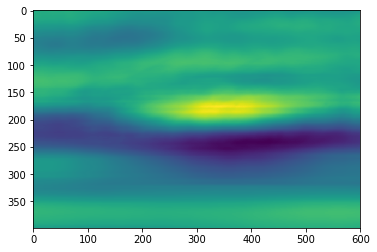

In [51]:
#scale down the car_filter:
small_car_filter = im.imresize(car_filter, (int(len(car_filter)/6), int(len(car_filter[0])/6)))
plt.imshow(make_heatmap(car1, small_car_filter))

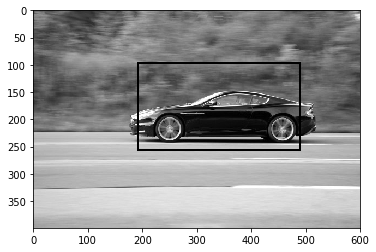

In [52]:
#compute bounding box for car1:
car1_predicted_bb = bounding_box(car1, small_car_filter, 0, True)

In [53]:
print(car1_predicted_bb)

[[[489.0, 96.0], [193.0, 96.0], [193.0, 256.0], [489.0, 256.0], [0, 0]]]


In [54]:
def car_compare_bounding_boxes(predicted, ground_truth):
    
    #get the x and y limits of the predicted bounding box:
    p_ux = int(predicted[0][0])
    p_lx = int(predicted[2][0])
    p_ly = int(predicted[0][1])
    p_uy = int(predicted[2][1])
    
    #get the x and y limits of the ground truth bounding box:
    g_ux = int(ground_truth[2])
    g_lx = int(ground_truth[0])
    g_ly = int(ground_truth[1])
    g_uy = int(ground_truth[3])
    
    #compute the percentage of pixels that are common:
    common_pixels = 0.0
    total = 0.0
    
    for x in range(p_lx, p_ux):
        for y in range(p_ly, p_uy):
            
            #check if the ground truth pixel is in range of the predicted
            if x >= g_lx and x <= g_ux and y >= g_ly and y <= g_uy:
                common_pixels += 1
            total += 1
    out = (common_pixels / total)*100
    
    return out

def make_gt_coordinates(my_list):
    out = [[my_list[0], my_list[3]], [my_list[0], my_list[1]], \
          [my_list[2], my_list[1]], [my_list[2], my_list[3]], [0,0]]
    return out

In [56]:
car1_gt = [175, 145, 522, 245]
rercentage = car_compare_bounding_boxes(car1_predicted_bb[0], car1_gt)
print(rercentage)

63.125


In [104]:
hamburger.append([0,0])
print(hamburger)

[(489.0, 96.0), (193.0, 145), (193.0, 256.0), (489.0, 245), [0, 0]]


In [61]:
copy = car1_predicted_bb
car1_gt_coordinates = make_gt_coordinates(car1_gt)
copy.append(car1_gt_coordinates)
car1_colors = ['b', 'g', 'm']



2
[[489.0, 96.0], [193.0, 96.0], [193.0, 256.0], [489.0, 256.0], [0, 0]]
[[175, 245], [175, 145], [522, 145], [522, 245], [0, 0]]
0
1


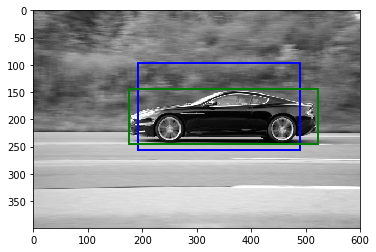

In [62]:
print(len(copy))
for hotdog in copy:
    print(hotdog)
plot_square_colors(copy, 0, len(car1[0]), 0, len(car1), car1, car1_colors)

In [138]:
#car2:
small_car2_filter = im.imresize(car_filter, (int(len(car_filter)/5), int(len(car_filter[0])/5)))
reversed_small_car_filter = np.fliplr(small_car2_filter)

In [ ]:
car2_predicted_bb = bounding_box(car2, reversed_small_car_filter, 0, True)

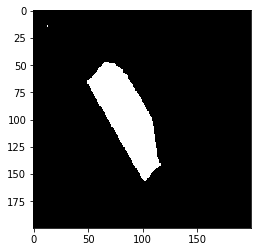

In [64]:
plt.imshow(o_clean, cmap="gray")